In [6]:
# !pip install numpy pandas librosa soundfile matplotlib scikit-learn tensorflow==2.15.0 sounddevice==0.4.6

import os, json, math, time, sys, uuid
from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd
import soundfile as sf
import librosa

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from IPython.display import Audio, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# -------------------
# Global config
# -------------------
CSV_PATH      = "../data/hoest/labels_export.csv"   # pas aan naar jouw pad
ROOT_AUDIO    = "../data/hoest/"                   # root van audio; 'filename' in csv is relatief hieraan

# audio/feature
TARGET_SR: int = 16000                 # jouw opnames zijn 15750/16000 -> resample naar 16000
FRAME_LEN_S: float = 3.0               # vaste duur per sample (pad/crop)
N_FFT: int = 1024
HOP: int  = 256
WIN: int  = 1024                       # zelfde als N_FFT (Hann)
FMIN: int = 20
FMAX: Optional[int] = None             # None => sr/2
TOP_DB: float = 80.0                   # voor visualisatie/normalisatie

# afgeleide dims (géén center, zodat shapes deterministisch zijn)
FRAME_LEN_SAMPLES = int(round(FRAME_LEN_S * TARGET_SR))
F_BINS = 1 + N_FFT // 2
T_BINS = 1 + max(0, (FRAME_LEN_SAMPLES - N_FFT)) // HOP

print("Expected STFT shape (F,T):", F_BINS, T_BINS)

Expected STFT shape (F,T): 513 184


In [16]:
df = pd.read_csv(CSV_PATH)
print(df.head(3))
print("\nKolommen:", list(df.columns))

         date                   filename  t_start  t_end    label  gender  \
0  2025-09-23  T16_27_42_D22_09_2025.wav      2.0    5.0    Hoest     NaN   
1  2025-09-23  T16_27_42_D22_09_2025.wav      5.0    8.0  Normaal     NaN   
2  2025-09-23  T16_27_42_D22_09_2025.wav      9.0   12.0    Hoest     NaN   

   age  location  
0  NaN       NaN  
1  NaN       NaN  
2  NaN       NaN  

Kolommen: ['date', 'filename', 't_start', 't_end', 'label', 'gender', 'age', 'location']


In [17]:
# label_primary afleiden: eerste token (split op ';'), trimmen
def to_primary_label(s: str) -> str:
    if not isinstance(s, str) or s.strip() == "":
        return "Onbekend"
    tok = s.split(";")[0].strip()
    return tok if tok else "Onbekend"

df["label_primary"] = df["label"].apply(to_primary_label)

# Eventueel filteren op 2 klassen (bijv. 'Hoest' vs 'Normaal'); laat lege weg
# Als je ALLES wilt houden, comment de volgende 2 regels uit
keep = df["label_primary"].isin(["Hoest", "Normaal"])
df = df[keep].reset_index(drop=True)

print(df["label_primary"].value_counts())
print(len(df), "segment-rijen")

label_primary
Normaal    68
Hoest      26
Name: count, dtype: int64
94 segment-rijen


In [18]:
def load_audio_full(rel_path: str, target_sr: int) -> np.ndarray:
    """Laad een WAV (mono) en resample naar target_sr."""
    path = os.path.join(ROOT_AUDIO, rel_path)
    y, sr = sf.read(path, dtype="float32", always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr, res_type="kaiser_best")
    return y

def fix_segment_bounds(t0: float, t1: float, dur: float, frame_len_s: float, tol: float = 1e-3) -> Tuple[float, float]:
    """
    Zorg dat elk segment exact 'frame_len_s' duurt.
    - Als (t1 - t0) ≈ frame_len_s -> OK (snappen op 2 dec)
    - Als te kort/te lang: maak het precies frame_len_s door end = start + frame_len_s
      en schuif naar links als we over het einde komen.
    """
    t0 = float(t0); t1 = float(t1)
    want = float(frame_len_s)
    have = t1 - t0

    if abs(have - want) <= tol:
        a = round(max(0.0, min(t0, max(0.0, dur - want))), 2)
        b = round(min(dur, a + want), 2)
        return a, b

    # maak exact frame_len_s
    a = t0
    b = a + want
    if b > dur:
        a = max(0.0, dur - want)
        b = a + want
    return round(a, 2), round(b, 2)

def load_audio_segment(rel_path: str, t0: float, t1: float, target_sr: int, ensure_len: bool = True) -> np.ndarray:
    """Knip segment [t0, t1) uit bestand en resample. Pad of crop naar FRAME_LEN_SAMPLES indien nodig."""
    y_full = load_audio_full(rel_path, target_sr)
    dur = len(y_full) / target_sr
    if ensure_len:
        t0, t1 = fix_segment_bounds(t0, t1, dur, FRAME_LEN_S)

    a = int(round(t0 * target_sr))
    b = int(round(t1 * target_sr))
    a = max(0, min(a, len(y_full)))
    b = max(0, min(b, len(y_full)))
    y = y_full[a:b]

    # pad/crop naar exacte lengte in samples
    if len(y) < FRAME_LEN_SAMPLES:
        y = np.pad(y, (0, FRAME_LEN_SAMPLES - len(y)))
    elif len(y) > FRAME_LEN_SAMPLES:
        y = y[:FRAME_LEN_SAMPLES]
    return y.astype(np.float32)

# simpele pre-emphasis (ruisonderdruk / hoogfrequent detail accentueren)
def pre_emphasis(y: np.ndarray, coef: float = 0.97) -> np.ndarray:
    if len(y) < 2:
        return y
    out = np.empty_like(y)
    out[0] = y[0]
    out[1:] = y[1:] - coef * y[:-1]
    return out

def compute_stft_db(y: np.ndarray, sr: int, n_fft: int = N_FFT, hop: int = HOP,
                    win: int = WIN, center: bool = False) -> np.ndarray:
    """
    |Y| in dB met max=0dB (genormaliseerd per segment).
    Output shape: (F_BINS, T) waar F_BINS = 1 + n_fft//2.
    """
    # optioneel: denoise/pre-emphasis
    y = pre_emphasis(y)

    # STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win,
                     window="hann", center=center)
    mag = np.abs(S).astype(np.float32)

    # normaliseer naar max==1
    mmax = mag.max() if mag.size else 1.0
    if mmax <= 1e-12:
        mmax = 1.0
    mag = mag / mmax

    S_db = 20.0 * np.log10(np.maximum(mag, 1e-6))  # in [-120, 0]
    return S_db

def fix_time_bins_stft(S_db: np.ndarray, t_bins: int = T_BINS) -> np.ndarray:
    """Pad of crop de tijd-as van het STFT dB-beeld naar t_bins."""
    F, T = S_db.shape
    if T < t_bins:
        pad = np.full((F, t_bins - T), -120.0, dtype=np.float32)
        S_db = np.concatenate([S_db, pad], axis=1)
    elif T > t_bins:
        S_db = S_db[:, :t_bins]
    return S_db

def spectrogram_to_01(S_db: np.ndarray, top_db: float = TOP_DB) -> np.ndarray:
    """
    Map dB [-top_db, 0] → [0,1].
    Alles < -top_db wordt op 0 gezet.
    """
    S_clipped = np.clip(S_db, -top_db, 0.0)
    return (S_clipped + top_db) / top_db

In [19]:
# Controleer en corrigeer segmentlengtes if needed; laat aantal correcties zien
def check_and_fix_lengths(df_segments: pd.DataFrame) -> pd.DataFrame:
    fixed = 0
    rows = []
    for _, row in df_segments.iterrows():
        rel = row["filename"]
        dur_s = len(load_audio_full(rel, TARGET_SR)) / TARGET_SR
        a, b = float(row["t_start"]), float(row["t_end"])
        a2, b2 = fix_segment_bounds(a, b, dur_s, FRAME_LEN_S)
        if abs((b - a) - FRAME_LEN_S) > 1e-3 or abs(a - a2) > 1e-6 or abs(b - b2) > 1e-6:
            fixed += 1
        row = row.copy()
        row["t_start"] = a2
        row["t_end"]   = b2
        rows.append(row)
    print(f"Segments fixed/normalized: {fixed} / {len(df_segments)}")
    return pd.DataFrame(rows)

df_segments = check_and_fix_lengths(df.copy())
df_segments.head(3)

Segments fixed/normalized: 7 / 94


,date,filename,t_start,t_end,label,gender,age,location,label_primary
0,2025-09-23,T16_27_42_D22_09_2025.wav,2.0,5.0,Hoest,NaN,NaN,NaN,Hoest
1,2025-09-23,T16_27_42_D22_09_2025.wav,5.0,8.0,Normaal,NaN,NaN,NaN,Normaal
2,2025-09-23,T16_27_42_D22_09_2025.wav,9.0,12.0,Hoest,NaN,NaN,NaN,Hoest


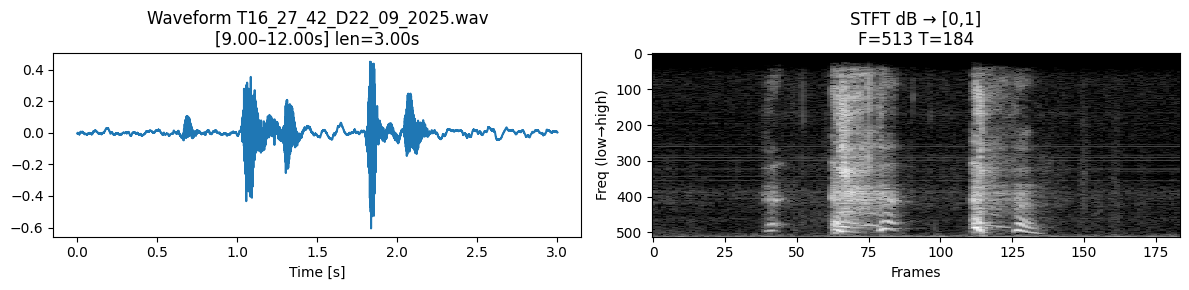

In [20]:
def preview_segment(row, sr=TARGET_SR):
    rel = row["filename"]
    a, b = float(row["t_start"]), float(row["t_end"])
    y = load_audio_segment(rel, a, b, sr)

    # plot waveform
    t = np.arange(len(y)) / sr
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    ax[0].plot(t, y)
    ax[0].set_title(f"Waveform {rel}\n[{a:.2f}–{b:.2f}s] len={len(y)/sr:.2f}s")
    ax[0].set_xlabel("Time [s]")

    # stft
    S_db = compute_stft_db(y, sr, N_FFT, HOP, WIN, center=False)
    S_db = fix_time_bins_stft(S_db, T_BINS)
    img = spectrogram_to_01(S_db, TOP_DB)

    ax[1].imshow(img[::-1, :], aspect="auto", interpolation="nearest", cmap="gray")
    ax[1].set_title(f"STFT dB → [0,1]\nF={img.shape[0]} T={img.shape[1]}")
    ax[1].set_xlabel("Frames"); ax[1].set_ylabel("Freq (low→high)")

    plt.tight_layout()
    plt.show()

    # playback
    display(Audio(y, rate=sr))

# Kies een willekeurig segment
preview_segment(df_segments.sample(1, random_state=0).iloc[0])

In [21]:
# label-encoder (string -> int)
le = LabelEncoder()
df_segments["y"] = le.fit_transform(df_segments["label_primary"])
class_names = list(le.classes_)
n_classes = len(class_names)
print("Klassen:", class_names)

# bouw X, y
X_list, y_list, groups = [], [], []
for _, row in df_segments.iterrows():
    rel = row["filename"]
    a, b = float(row["t_start"]), float(row["t_end"])
    y_seg = load_audio_segment(rel, a, b, TARGET_SR)
    S_db  = compute_stft_db(y_seg, TARGET_SR, N_FFT, HOP, WIN, center=False)
    S_db  = fix_time_bins_stft(S_db, T_BINS)
    X_list.append(spectrogram_to_01(S_db, TOP_DB)[..., None])  # (F,T,1)
    y_list.append(int(row["y"]))
    groups.append(rel)  # per bestand splitten

X = np.stack(X_list).astype(np.float32)
y = np.array(y_list, dtype=np.int64)
groups = np.array(groups)
print("X shape:", X.shape, "y shape:", y.shape)

Klassen: ['Hoest', 'Normaal']
X shape: (94, 513, 184, 1) y shape: (94,)


In [22]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, val_idx), = gss.split(X, y, groups=groups)

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]

print("Train:", X_train.shape, "Val:", X_val.shape)
print("Class balance (train):", np.bincount(y_train, minlength=n_classes))
print("Class balance (val)  :", np.bincount(y_val,   minlength=n_classes))


Train: (76, 513, 184, 1) Val: (18, 513, 184, 1)
Class balance (train): [21 55]
Class balance (val)  : [ 5 13]


In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # type: ignore

input_shape = (F_BINS, T_BINS, 1)

def build_cnn(num_classes: int) -> keras.Model:
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

model = build_cnn(n_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 513, 184, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 513, 184, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 513, 184, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 92, 16)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 376832)            0         
                                                                 
 dense (Dense)               (None, 128)               48234624  
                                                             

Epoch 1/30
3/3 [==============================] - 3s 733ms/step - loss: 2.1901 - accuracy: 0.5000 - val_loss: 1.9135 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 2/30
3/3 [==============================] - 2s 603ms/step - loss: 3.4303 - accuracy: 0.7237 - val_loss: 0.0067 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/30
3/3 [==============================] - 2s 674ms/step - loss: 0.9570 - accuracy: 0.8553 - val_loss: 4.7684e-07 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/30
3/3 [==============================] - 2s 649ms/step - loss: 0.1497 - accuracy: 0.9342 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/30
3/3 [==============================] - 2s 625ms/step - loss: 5.3957e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/30
3/3 [==============================] - ETA: 0s - loss: 3.1460e-05 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
3/3 [==============================] - 2s 575ms

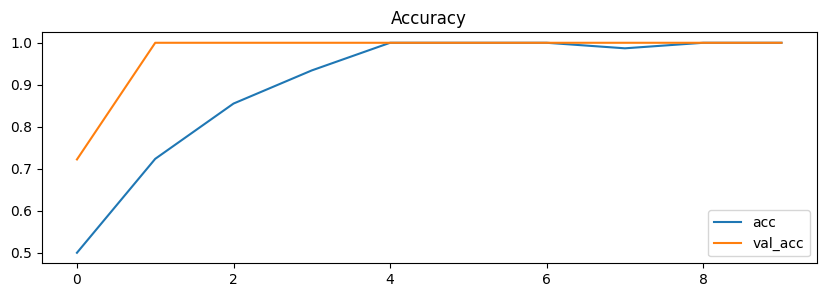

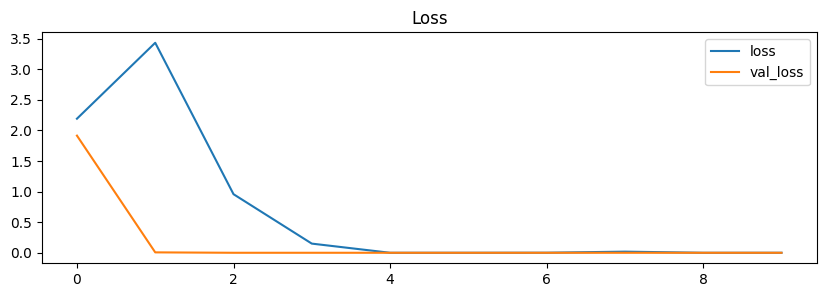

In [24]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1  # type: ignore
)

plt.figure(figsize=(10,3))
plt.plot(hist.history["accuracy"], label="acc") # type: ignore
plt.plot(hist.history["val_accuracy"], label="val_acc") # type: ignore
plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure(figsize=(10,3))
plt.plot(hist.history["loss"], label="loss") # type: ignore
plt.plot(hist.history["val_loss"], label="val_loss") # type: ignore
plt.legend(); plt.title("Loss"); plt.show()


1/1 [==============================] - 0s 116ms/step
              precision    recall  f1-score   support

       Hoest      1.000     1.000     1.000         5
     Normaal      1.000     1.000     1.000        13

    accuracy                          1.000        18
   macro avg      1.000     1.000     1.000        18
weighted avg      1.000     1.000     1.000        18



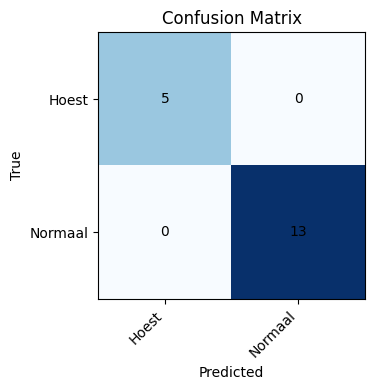

In [25]:
y_pred = model.predict(X_val, batch_size=64).argmax(axis=1)

cm = confusion_matrix(y_val, y_pred, labels=list(range(n_classes)))
print(classification_report(y_val, y_pred, target_names=class_names, digits=3))

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(n_classes), class_names, rotation=45, ha="right")
plt.yticks(range(n_classes), class_names)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


In [26]:
MODEL_DIR = "export_model"
os.makedirs(MODEL_DIR, exist_ok=True)

keras_path = os.path.join(MODEL_DIR, "cnn_stft_keras.h5")
model.save(keras_path)
print("Saved:", keras_path)

# TFLite export
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = os.path.join(MODEL_DIR, "cnn_stft.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print("Saved:", tflite_path)

# labels en feature-params opslaan
meta = {
    "class_names": class_names,
    "TARGET_SR": TARGET_SR,
    "FRAME_LEN_S": FRAME_LEN_S,
    "N_FFT": N_FFT,
    "HOP": HOP,
    "WIN": WIN,
    "TOP_DB": TOP_DB,
    "F_BINS": F_BINS,
    "T_BINS": T_BINS,
    "center": False,   # BELANGRIJK: live en train identiek
}
with open(os.path.join(MODEL_DIR, "meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)
print("Saved: meta.json")


c:\Users\MSI\Documents\Persoonlijke Projecten\Lungsound-Annotation-Tool\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved: export_model\cnn_stft_keras.h5
INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpyc1_ga54\assets


INFO:tensorflow:Assets written to: C:\Users\MSI\AppData\Local\Temp\tmpyc1_ga54\assets


Saved: export_model\cnn_stft.tflite
Saved: meta.json


In [27]:
import sounddevice as sd
from collections import deque

class Predictor:
    def __init__(self, model_path: str):
        if model_path.endswith(".tflite"):
            self.is_tflite = True
            self.interpreter = tf.lite.Interpreter(model_path=model_path)
            self.interpreter.allocate_tensors()
            self.in_det  = self.interpreter.get_input_details()[0]
            self.out_det = self.interpreter.get_output_details()[0]
        else:
            self.is_tflite = False
            self.model = keras.models.load_model(model_path)

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        """
        x shape: (1, F_BINS, T_BINS, 1), float32 in [0,1]
        returns: (C,)
        """
        if self.is_tflite:
            x = x.astype(np.float32)
            self.interpreter.set_tensor(self.in_det["index"], x)
            self.interpreter.invoke()
            out = self.interpreter.get_tensor(self.out_det["index"])
            return out[0]
        else:
            return self.model.predict(x, verbose=0)[0] # type: ignore

def stft_feature_from_audio(y: np.ndarray, sr: int) -> np.ndarray:
    """Volledig identiek aan training: STFT dB -> [0,1], (F,T) -> (F,T_BINS,1)."""
    # pas lengte aan naar exact 3.0s
    if len(y) < FRAME_LEN_SAMPLES:
        y = np.pad(y, (0, FRAME_LEN_SAMPLES - len(y)))
    elif len(y) > FRAME_LEN_SAMPLES:
        y = y[:FRAME_LEN_SAMPLES]
    S_db = compute_stft_db(y, sr, N_FFT, HOP, WIN, center=False)
    S_db = fix_time_bins_stft(S_db, T_BINS)
    feat = spectrogram_to_01(S_db, TOP_DB)[..., None]
    return feat.astype(np.float32)

def live_demo(model_path: str, class_names: List[str], duration: float = FRAME_LEN_S, device: Optional[int] = None):
    """
    Neemt elke 'duration' seconden op en toont de voorspelling (met lichte smoothing).
    Ctrl+C om te stoppen.
    """
    pred = Predictor(model_path)
    print("Loaded model:", "TFLite" if pred.is_tflite else "Keras")
    print("Classes:", class_names)

    sr = TARGET_SR
    block_len = FRAME_LEN_SAMPLES
    smoothing = 0.2
    p_smooth = None

    def _callback(indata, frames, time_info, status):
        pass  # we gebruiken sync opname hieronder (sd.rec)

    try:
        while True:
            print("\n--- Speak now ---")
            y = sd.rec(block_len, samplerate=sr, channels=1, dtype='float32', device=device)
            sd.wait()
            y = y[:,0]

            feat = stft_feature_from_audio(y, sr)
            x = feat[None, ...]  # (1,F,T,1)
            p = pred.predict_proba(x)

            # smooth
            if p_smooth is None:
                p_smooth = p
            else:
                p_smooth = (1.0 - smoothing) * p_smooth + smoothing * p

            top = int(np.argmax(p_smooth))
            msg = ", ".join([f"{cls}:{p_smooth[i]:.2f}" for i, cls in enumerate(class_names)])
            print(f"→ Pred: {class_names[top]} | {msg}")

    except KeyboardInterrupt:
        print("\nStopped.")

In [28]:
# Voorbeeld aanroep (zet device index als nodig):
MODEL_PATH = "export_model/cnn_stft.tflite"

with open("export_model/meta.json","r") as f:
    CLASS_NAMES = json.load(f)["class_names"]
live_demo(MODEL_PATH, CLASS_NAMES)  # Ctrl+C om te stoppen

Loaded model: TFLite
Classes: ['Hoest', 'Normaal']

--- Speak now ---
→ Pred: Normaal | Hoest:0.00, Normaal:1.00

--- Speak now ---
→ Pred: Normaal | Hoest:0.20, Normaal:0.80

--- Speak now ---
→ Pred: Normaal | Hoest:0.36, Normaal:0.64

--- Speak now ---
→ Pred: Normaal | Hoest:0.49, Normaal:0.51

--- Speak now ---
→ Pred: Hoest | Hoest:0.59, Normaal:0.41

--- Speak now ---
→ Pred: Hoest | Hoest:0.67, Normaal:0.33

--- Speak now ---
→ Pred: Hoest | Hoest:0.74, Normaal:0.26

--- Speak now ---
→ Pred: Hoest | Hoest:0.79, Normaal:0.21

--- Speak now ---
→ Pred: Hoest | Hoest:0.63, Normaal:0.37

--- Speak now ---
→ Pred: Hoest | Hoest:0.51, Normaal:0.49

--- Speak now ---
→ Pred: Normaal | Hoest:0.40, Normaal:0.60

--- Speak now ---
→ Pred: Normaal | Hoest:0.32, Normaal:0.68

--- Speak now ---
→ Pred: Normaal | Hoest:0.26, Normaal:0.74

--- Speak now ---
→ Pred: Normaal | Hoest:0.21, Normaal:0.79

--- Speak now ---
→ Pred: Normaal | Hoest:0.37, Normaal:0.63

--- Speak now ---
→ Pred: Norm